# Batina Advanced Weight Recovery

This notebook demonstrates how to guess a floating number using Hamming Weight model.

We generate a random secret floating number. Then we use hamming weight model to guess the number.


In [1]:
import pathlib
TEST_RESULT_DIR = './results'

pathlib.Path(TEST_RESULT_DIR).mkdir(parents=True, exist_ok=True) 

In [2]:
import sys
sys.path.append("../")

from pybatina.advanced_weight_recovery import *
from pybatina.utils import *

In [33]:
import numpy as np

guess_range=(-5.0, 5.0)
# the number of guess values in the guess range
secret_number = np.random.uniform(guess_range[0], guess_range[1]) 
secret_number = 4.999
secret_number = int_to_float(float_to_int(secret_number))
print('secret_number =', secret_number)

secret_number = 4.999000072479248


In [34]:
number_of_best_candidates = 15
awr = AdvancedWeightRecovery(guess_range=guess_range, number_of_best_candidates=number_of_best_candidates)

## ONE STEP

In [35]:
secret_hamming_weight_set = [np.vectorize(hamming_weight)(input_values * secret_number) for input_values in awr.input_value_set]    
s = awr.recover_weight(secret_hamming_weight_set)
s.iloc[:awr.number_of_best_candidates]

<ipython-input-35-9a5bf5d30195>:1: RuntimeWarning: overflow encountered in multiply
  secret_hamming_weight_set = [np.vectorize(hamming_weight)(input_values * secret_number) for input_values in awr.input_value_set]
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: overflow encountered in ? (vectorized)
  outputs = ufunc(*inputs)


 4.999000    1.000000
 4.999003    0.999512
 4.998998    0.999512
 4.998999    0.999512
 4.999000    0.999512
 4.999002    0.999512
 4.999002    0.997883
 4.998998    0.997883
 4.998999    0.997883
 4.999001    0.997883
 4.999002    0.997883
 4.999001    0.994820
-4.999000    0.919236
-4.999000    0.915441
-4.999001    0.903577
dtype: float64

## STEP-BY-STEP

### Correlation of mantissa

In [36]:
%%time

numbers = None
mantissa_correlations = {}
for mantissa_byte_index in range(len(AdvancedWeightRecovery.MANTISSA_THREE_BYTES)):
    guess_numbers = awr.build_guess_values(component='mantissa', mantissa_byte_index=mantissa_byte_index, numbers=numbers)
    known_inputs = awr.build_input_values(component='mantissa', mantissa_byte_index=mantissa_byte_index)
    secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number).astype(np.float32)
    mantissa_corr = awr.compute_corr_numbers(secret_hw, known_inputs, guess_numbers).sort_values(ascending=False)
    mantissa_correlations[mantissa_byte_index] = mantissa_corr
    numbers = mantissa_corr.index[:awr.number_of_best_candidates]

CPU times: user 15.7 s, sys: 480 ms, total: 16.2 s
Wall time: 16.2 s


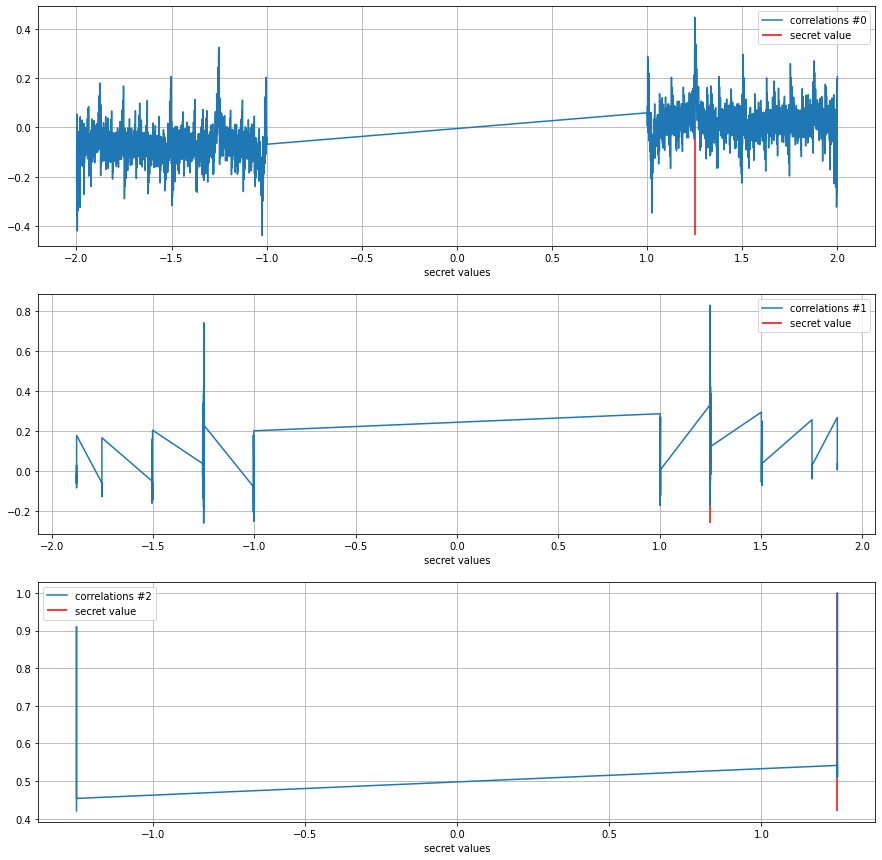

In [37]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(nrows=len(mantissa_correlations), ncols=1, figsize=(15, 5 * len(mantissa_correlations)))
for idx in range(len(mantissa_correlations)):
    corr = mantissa_correlations[idx].sort_index()
    corr.plot(ax=ax[idx], label='correlations #%d' % idx)
    x = int_to_float((float_to_int(secret_number) & ~(0xff<<AdvancedWeightRecovery.MAX_MANTISSA_NBITS)) | (127<<AdvancedWeightRecovery.MAX_MANTISSA_NBITS))
    ax[idx].vlines(x, corr.min(), corr.max(), color='red', label='secret value')
    ax[idx].legend()
    ax[idx].grid(True)
    ax[idx].set_xlabel('secret values')

In [38]:
numbers=mantissa_corr.index[:awr.number_of_best_candidates]
numbers

Float64Index([  1.249750018119812,  -1.249750018119812,  1.2497501373291016,
               1.2497498989105225,  1.2497502565383911,   1.249749779701233,
               1.2497503757476807,  1.2497496604919434,  1.2497504949569702,
               1.2497495412826538, -1.2497501373291016,  1.2497506141662598,
              -1.2497498989105225,  1.2497494220733643,  1.2497507333755493],
             dtype='float64')

### Correlation exponent

In [39]:
%%time
known_inputs = awr.build_input_values(component='exponent')
secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number)
guess_numbers = awr.build_guess_values(component='exponent', numbers=numbers)
guess_numbers = guess_numbers[np.where(np.logical_and(guess_numbers >= guess_range[0], guess_numbers <= guess_range[1]))]
mantisa_exp_corr = awr.compute_corr_numbers(secret_hw, known_inputs, guess_numbers).sort_values(ascending=False)

<timed exec>:2: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
<timed exec>:4: RuntimeWarning: invalid value encountered in greater_equal
<timed exec>:4: RuntimeWarning: invalid value encountered in less_equal
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: overflow encountered in ? (vectorized)
  outputs = ufunc(*inputs)


CPU times: user 889 ms, sys: 8.02 ms, total: 897 ms
Wall time: 896 ms


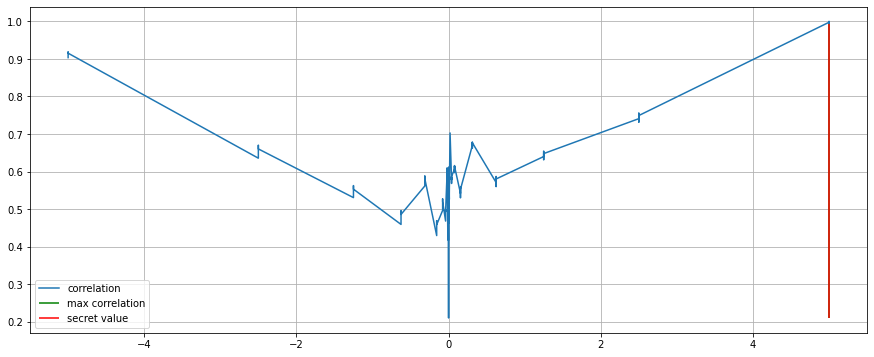

In [40]:
ax = mantisa_exp_corr.sort_index().plot(figsize=(15,6), label='correlation')
ax.vlines(mantisa_exp_corr.idxmax(), mantisa_exp_corr.min(), mantisa_exp_corr.max(), color='green', label='max correlation')
ax.vlines(secret_number, mantisa_exp_corr.min(), mantisa_exp_corr.max(), color='red', label='secret value')
ax.legend()
ax.grid()

In [41]:
print('secret_number:', secret_number)
mantisa_exp_corr.iloc[:number_of_best_candidates]

secret_number: 4.999000072479248


 4.999000    1.000000
 4.998998    0.999512
 4.999003    0.999512
 4.999002    0.999512
 4.999000    0.999512
 4.998999    0.999512
 4.999002    0.997883
 4.999002    0.997883
 4.999001    0.997883
 4.998998    0.997883
 4.998999    0.997883
 4.999001    0.994820
-4.999000    0.919236
-4.999000    0.915441
-4.999001    0.903577
dtype: float64